In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
from scipy import stats
import tese_func
from sklearn.feature_selection import mutual_info_classif, f_classif, chi2
import heapq
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import recall_score, precision_score, make_scorer
from functools import partial
from tqdm import tqdm
import time
from collections import defaultdict
from scipy.stats import spearmanr, pearsonr
from scipy.cluster import hierarchy
import random
from collections import Counter
rs = 1
calc=True

from matplotlib import pyplot
plt.style.use({'figure.facecolor':'white'})

In [3]:
data = pd.read_csv("data/data_ipet.csv")
clin = 766
target = "ipet2"

reps = {"I A": 1, "I B":2, "II A":3, "II B":4, "III A":5, "III B":6, "IV A":7, "IV B":8}

data["stage"] = data["stage"].replace(reps)
data["lmr>2.1"] = data["lmr>2.1"].astype('int64')

selgenes = ["CXCL2", "CXCL3", "CCL18", "TREM1", "SAA1", "PLAU", "FN1",
            "SPP1", "ITGA5", "CD9", "LRP1", "THBS1", "VEGFA"]

clinic = data.iloc[:,clin:]
gene = data.iloc[:,1:clin]
gene[target] = data[target]

print(data.shape)
data.head()

(103, 771)


,id,A2M,ABCB1,ABCF1,ABL1,ADA,ADORA2A,AGK,AICDA,AIRE,...,ZC3H14,ZKSCAN5,ZNF143,ZNF205,ZNF346,gender,age,stage,lmr>2.1,ipet2
0,GSM3860476,10.61,7.83,10.09,8.34,8.48,8.90,7.30,0.36,6.44,...,8.93,5.38,7.88,3.59,7.15,0,18,3,1,0
1,GSM3860477,11.14,11.88,1.70,10.60,10.58,11.45,10.90,1.70,11.42,...,10.27,8.77,1.70,1.70,10.75,1,51,3,1,0
2,GSM3860478,9.91,9.94,9.04,8.60,9.67,9.56,9.51,0.16,9.43,...,9.51,7.68,7.58,2.63,8.62,1,38,3,0,0
3,GSM3860479,11.89,8.56,9.99,8.47,9.54,8.61,8.10,1.35,6.68,...,9.69,6.36,8.91,1.35,8.25,0,50,8,0,0
4,GSM3860480,9.69,7.15,9.27,8.29,8.39,8.14,7.17,0.66,5.43,...,9.40,5.72,7.79,5.07,7.43,1,22,3,1,0


In [4]:
selgenes = ["CXCL2", "CXCL3", "CCL18", "TREM1", "SAA1", "PLAU", "FN1",
            "SPP1", "ITGA5", "CD9", "LRP1", "THBS1", "VEGFA"]
clinic_var = ["gender", "age","stage", "lmr>2.1"]

union, inter, pv_mi,pv_wi = tese_func.feat_select_miwi(threshold=0.05, prev_sel=selgenes)
print("-"*80)
union1, inter1, _, _ = tese_func.feat_select_miwi(threshold=0.1, prev_sel=selgenes)

#remover vars clinicas
union_g = [x for x in union if x not in clinic_var]
inter_g = [x for x in inter if x not in clinic_var]
union1_g = [x for x in union1 if x not in clinic_var]
inter1_g = [x for x in inter1 if x not in clinic_var]
print("-"*80)

Features mi with p-value <= 0.05: 97
Features wi with p-value <= 0.05: 99

Union of features from MI and Wilcoxon has len: 174 
Intersection of features from MI and Wilcoxon has len: 22 

Previously selected in union: ['CD9', 'CXCL2', 'THBS1', 'SAA1', 'ITGA5', 'VEGFA']
Previously selected in intersection: []
--------------------------------------------------------------------------------
Features mi with p-value <= 0.1: 155
Features wi with p-value <= 0.1: 132

Union of features from MI and Wilcoxon has len: 250 
Intersection of features from MI and Wilcoxon has len: 37 

Previously selected in union: ['CD9', 'CXCL2', 'LRP1', 'THBS1', 'SAA1', 'FN1', 'ITGA5', 'VEGFA', 'CXCL3']
Previously selected in intersection: []
--------------------------------------------------------------------------------


In [5]:
df = data[["id"]+union1+[target]]
display(df)
df.to_csv("./data/dataset_union1.csv", index=False)

,id,MAP4K2,HLA-E,ELANE,TNFSF13,DHX16,ICOSLG,LY86,MAP3K1,PSMB10,...,GNLY,C3,JAK3,GZMM,VEGFA,CD40LG,XCR1,RUNX1,MERTK,ipet2
0,GSM3860476,9.07,13.86,0.36,10.04,8.72,8.18,7.42,9.41,11.65,...,8.26,10.09,12.20,9.83,8.48,8.19,7.51,9.89,8.31,0
1,GSM3860477,3.61,10.41,1.70,12.14,1.70,10.79,10.06,1.70,11.03,...,11.18,8.11,3.61,10.80,8.71,9.60,11.06,1.70,1.70,0
2,GSM3860478,9.14,12.96,0.16,10.40,8.42,9.45,9.35,9.13,11.11,...,8.68,9.78,11.74,10.03,8.82,8.97,8.96,8.71,6.75,0
3,GSM3860479,8.62,13.92,1.35,8.96,8.49,8.69,8.35,10.35,11.66,...,7.71,10.54,11.94,10.66,8.89,9.35,7.92,9.51,9.42,0
4,GSM3860480,9.10,13.36,0.66,9.90,8.71,7.99,5.63,9.02,10.85,...,8.41,9.20,11.88,8.61,10.73,7.15,5.38,10.35,8.58,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,GSM3860575,8.37,13.72,2.45,8.92,9.24,7.20,7.46,10.02,10.74,...,7.21,12.34,12.77,9.11,9.80,9.07,7.41,9.30,7.89,1
99,GSM3860576,8.22,13.49,4.58,9.28,8.87,7.88,9.06,9.13,10.92,...,9.31,11.72,10.86,3.55,12.23,6.38,5.18,9.77,7.69,1
100,GSM3860577,9.03,14.08,3.72,7.67,9.30,8.02,9.21,10.43,11.24,...,9.51,11.24,12.03,8.98,8.97,8.63,8.25,9.33,9.07,1
101,GSM3860578,8.48,13.72,1.44,9.83,9.36,7.64,6.38,9.78,10.63,...,7.52,11.07,12.09,6.67,10.81,7.89,4.86,10.88,10.69,1


In [6]:
n = 30
figsize = (16,6)
font_size=12
rot=0
ha = "center"

if n>20:   
    rot = 20
    ha = "right"

# SVM-RFE

Optimal number of features with Recall: 9
Optimal number of features with Precision: 66
Optimal number of features with F1-Score: 9


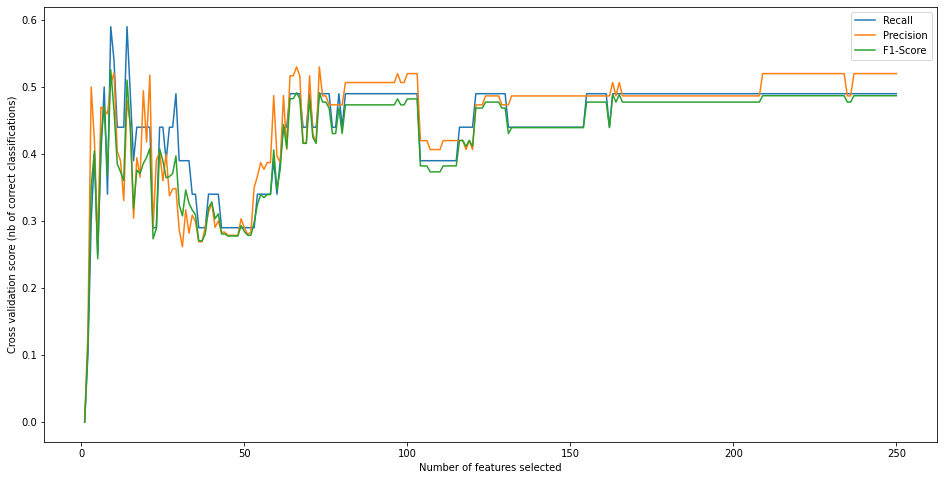

In [7]:
prec = make_scorer(partial(precision_score, zero_division = 0))
scorings = ["recall", prec, "f1"]
names = ["Recall", "Precision", "F1-Score"]
rfecvs = []
for n,s in zip(names,scorings):
    min_features_to_select = 1
    svc = SVC(kernel="linear")
    rfecv = RFECV(estimator=svc, step=1, cv=5, scoring=s, min_features_to_select=1)
    rfecv.fit(X, y)
    ranking = rfecv.ranking_
    #print(np.argmax(rfecv.grid_scores_))
    print(f"Optimal number of features with {n}: {rfecv.n_features_}")
    rfecvs.append(rfecv)
    
 

plt.figure(figsize=(16,8))

for n,rfecv in zip(names,rfecvs):
    # Plot number of features VS. cross-validation scores
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(min_features_to_select,len(rfecv.grid_scores_) + min_features_to_select),
             rfecv.grid_scores_, label=n)

plt.legend()
plt.show()

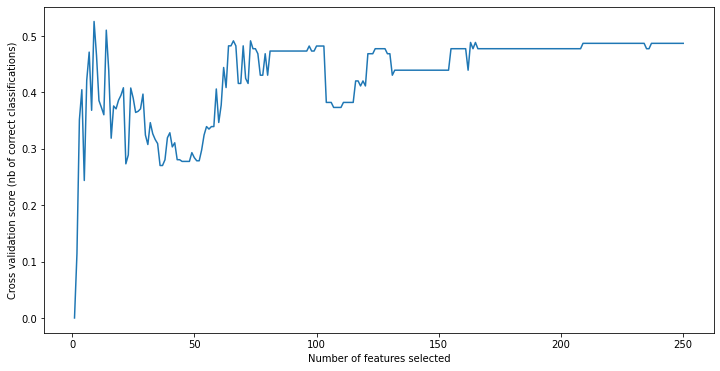

Number of features: 9
['VEGFA', 'MFGE8', 'TLR5', 'CD80', 'SH2D1A', 'S100B', 'CXCL2', 'IL12RB1', 'HLA-C']
['id', 'VEGFA', 'MFGE8', 'TLR5', 'CD80', 'SH2D1A', 'S100B', 'CXCL2', 'IL12RB1', 'HLA-C', 'CD8B', 'FCER2', 'CCL8', 'IL2', 'ENTPD1', 'ipet2']


,id,VEGFA,MFGE8,TLR5,CD80,SH2D1A,S100B,CXCL2,IL12RB1,HLA-C,CD8B,FCER2,CCL8,IL2,ENTPD1,ipet2
0,GSM3860476,8.48,10.29,6.46,9.64,9.62,7.10,9.02,9.54,14.04,8.97,7.83,8.19,0.36,9.93,0
1,GSM3860477,8.71,10.00,10.23,10.73,1.70,10.26,10.60,12.08,11.39,12.03,1.70,9.81,9.85,10.54,0
2,GSM3860478,8.82,9.92,8.65,9.15,9.54,8.69,9.02,9.72,12.82,9.64,10.08,8.33,9.11,9.52,0
3,GSM3860479,8.89,10.46,6.53,8.58,10.76,7.54,10.69,9.85,14.24,9.10,9.08,7.14,1.35,10.25,0
4,GSM3860480,10.73,9.36,5.32,9.18,8.89,6.71,10.61,8.95,13.16,7.25,9.32,6.89,0.66,10.32,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,GSM3860575,9.80,11.16,6.45,8.51,11.03,7.86,6.33,8.19,13.28,7.74,9.67,5.97,0.00,8.32,1
99,GSM3860576,12.23,10.87,6.36,9.78,8.62,7.40,8.14,8.18,13.87,6.95,7.50,10.79,0.16,8.43,1
100,GSM3860577,8.97,10.13,7.17,8.80,11.05,8.13,8.32,9.15,14.01,9.97,7.16,8.35,3.72,9.48,1
101,GSM3860578,10.81,11.51,6.33,9.50,9.42,7.54,7.89,9.17,13.69,3.96,1.44,9.13,1.44,10.62,1


In [8]:
df = data[union1+[target]]

path = "./feat_select/svm_rfe.csv" 
svc = SVC(kernel="linear")
svm_rfe, selected = tese_func.model_rfe(svc, df, target, path, scoring='f1', verbose=2)
vars = svm_rfe.head(14)["var"].tolist()
vars = ["id"] + vars + [target]
print(vars)
t = data[vars]
display(t)
t.to_csv("./data/dataset_svm.csv", index=False)

# RF RFE

Optimal number of features with F1-Score iteration 1: 10
Optimal number of features with F1-Score iteration 2: 48
Optimal number of features with F1-Score iteration 3: 44


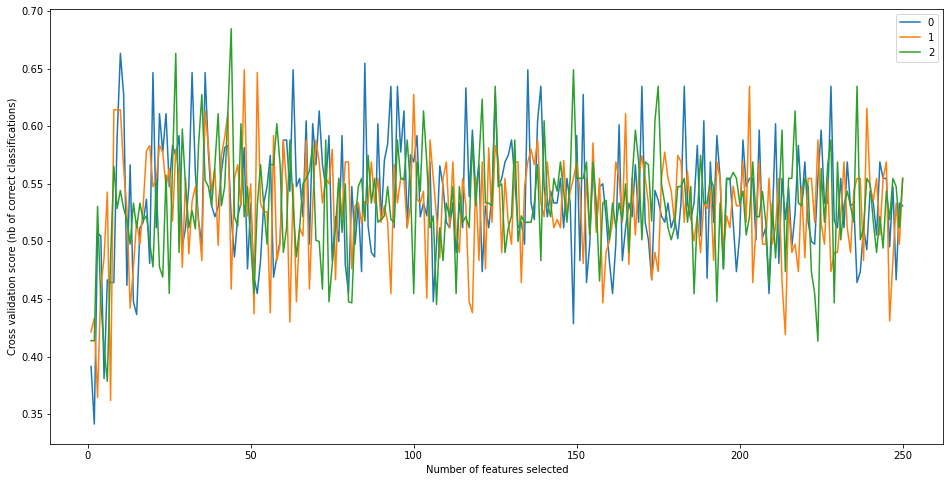

In [11]:
prec = make_scorer(partial(precision_score, zero_division = 0))
scoring = "f1"
name = "F1-Score"
rfecvs = []
N = 3
for i in range(N):
    min_features_to_select = 1
    rf = RandomForestClassifier()
    rfecv = RFECV(estimator=rf, step=1, cv=5, scoring=scoring, min_features_to_select=1)
    rfecv.fit(X, y)
    ranking = rfecv.ranking_
    #print(np.argmax(rfecv.grid_scores_))
    print(f"Optimal number of features with {name} iteration {i+1}: {rfecv.n_features_}")
    rfecvs.append(rfecv)



plt.figure(figsize=(16,8))

for j, rfecv in enumerate(rfecvs):
    # Plot number of features VS. cross-validation scores
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(min_features_to_select,len(rfecv.grid_scores_) + min_features_to_select),
             rfecv.grid_scores_, label=j)

plt.legend()
plt.show()

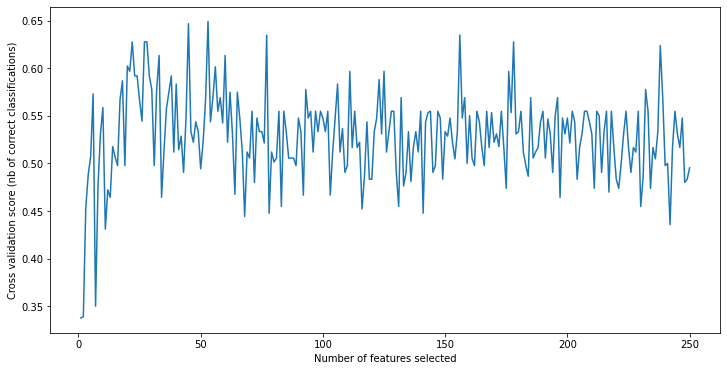

Number of features: 53
['SLC11A1', 'PLAUR', 'SYK', 'APP', 'TGFB2', 'CEBPB', 'BTK', 'VEGFA', 'CSF3R', 'CXCL2', 'MIF', 'ITGA5', 'ENTPD1', 'CXCL3', 'SMPD3', 'CXCL16', 'LRP1', 'MAGEB2', 'FLT3LG', 'CD276', 'IL12RB1', 'DUSP6', 'CD58', 'CASP3', 'ZAP70', 'CD3E', 'GPI', 'BATF', 'CD24', 'TLR7', 'SAA1', 'AXL', 'CCL5', 'PDGFRB', 'CD80', 'TCF7', 'SELL', 'PECAM1', 'CD180', 'SH2D1A', 'CCL21', 'ITGAE', 'LTB', 'FOS', 'CARD11', 'MX1', 'CD27', 'GNLY', 'CFP', 'IL1RN', 'ANP32B', 'ITK', 'CCL8']
['SLC11A1', 'PLAUR', 'SYK', 'APP', 'TGFB2', 'CEBPB', 'BTK', 'VEGFA', 'CSF3R', 'CXCL2', 'MIF', 'ITGA5', 'ENTPD1', 'CXCL3']


,var,imp
75,SLC11A1,1
181,PLAUR,2
230,SYK,3
99,APP,4
156,TGFB2,5
...,...,...
203,PIK3CG,246
170,CD22,247
29,CD4,248
204,SLAMF6,249


In [8]:
df = data[union1+[target]]

path = "./feat_select/rf_rfe.csv"
rf = RandomForestClassifier(random_state=rs)
rf_rfe, selected = tese_func.model_rfe(rf, df, target, path, scoring='f1', verbose=2)
print(rf_rfe.head(14)["var"].tolist())

# RF-based

In [10]:
#test inconsistency of algorithm
def test_rf(df, target,cv=5, scoring="f1", n_repeats=10):
    y = df[target]
    columns = df.drop(columns=[target]).columns
    X = df.drop(columns=[target]).values
    
    ###importances############################################3
    skf = StratifiedKFold(n_splits=cv, shuffle=True)
    results = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = RandomForestClassifier().fit(X_train, y_train)
        r = permutation_importance(clf, X_test, y_test, scoring=scoring, n_repeats=n_repeats)
        results.append(r.importances_mean)

    final = sum(results)/len(results)
    selected = list(columns[final>0])
    print("non-zero variables: {} of {} - {:.2f}%".format(len(selected), len(columns), len(selected)/len(final)*100))    
    return selected

if calc: 
    df = data[union1+[target]]
    n_repeats = 10
    selected = []

    for _ in tqdm(range(50)):
        s = test_rf(df, target, n_repeats=n_repeats)
        selected.append(s)

    with open('rf_test1', 'wb') as fp:
        pickle.dump(selected, fp)

  2%|▏         | 1/50 [02:06<1:43:07, 126.28s/it]

non-zero variables: 5 of 250 - 2.00%


  2%|▏         | 1/50 [02:47<2:17:01, 167.79s/it]


KeyboardInterrupt: 

<Figure size 864x864 with 0 Axes>

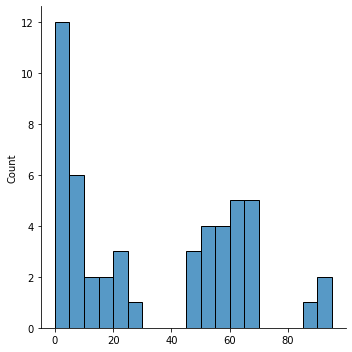

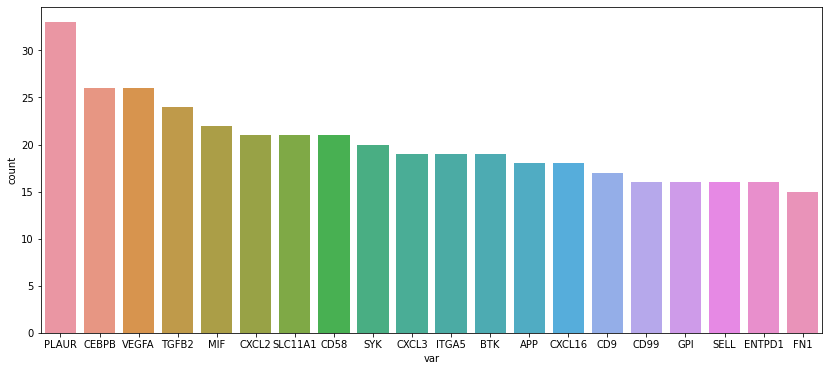

In [7]:
with open('rf_test1', 'rb') as fp:
    selected = pickle.load(fp)

lengths = [len(s) for s in selected]

plt.figure(figsize=(12,12))
sns.displot(lengths, binwidth=5)
plt.show()

flat = [item for sublist in selected for item in sublist]
count = dict(Counter(flat))

a = pd.DataFrame(flat, columns=["var"])

plt.figure(figsize=(14,6))
sns.countplot(data=a, x = "var", order=a["var"].value_counts().iloc[:20].index)
plt.show()

In [13]:
y = df[target].values
columns = df.drop(columns=[target]).columns
X = df.drop(columns=[target]).values

clf = RandomForestClassifier(random_state=42)
acc = np.mean(cross_val_score(clf, X, y, cv=5, scoring="accuracy"))
f1 =  np.mean(cross_val_score(clf, X, y, cv=5, scoring="f1"))
print("Accuracy using CV: {:.2f}".format(acc))
print("F1 using CV: {:.2f}".format(f1))

Accuracy using CV: 0.87
F1 using CV: 0.53


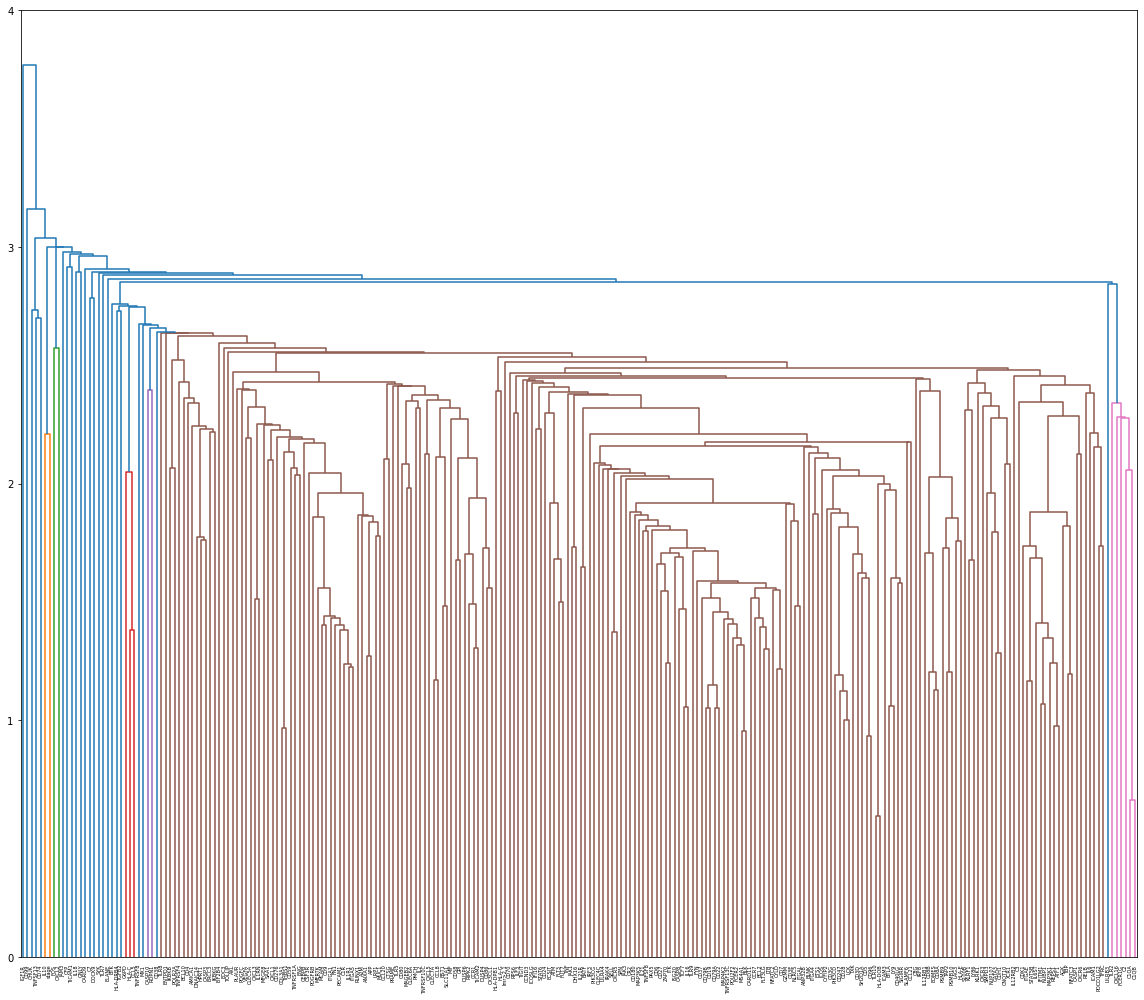

In [14]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 14))
corr = spearmanr(X).correlation   #usa spearman correlation
corr_linkage = hierarchy.single(corr)  #usa single linkage
dendro = hierarchy.dendrogram(corr_linkage, labels=columns.tolist(), ax=ax1, leaf_rotation=90)
u_limit = 4
ax1.set_ylim(0,u_limit)
ax1.set_yticks(list(range(0,u_limit+1)))
fig.tight_layout()
plt.show()

In [19]:
t = 2
cluster_ids = hierarchy.fcluster(corr_linkage, t, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
related_features = {v[0]: v[1:] for v in cluster_id_to_feature_ids.values()}
print("From {} features to {} features with threshold of {}".format(len(cluster_ids), len(selected_features), t))
X_sel = X[:, selected_features]

clf_sel = RandomForestClassifier(random_state=42)
acc = np.mean(cross_val_score(clf_sel, X_sel, y, cv=5, scoring="accuracy"))
f1 =  np.mean(cross_val_score(clf_sel, X_sel, y, cv=5, scoring="f1"))
print("Accuracy with features removed using CV: {:.2f}".format(acc))
print("F1 with features removed using CV: {:.2f}".format(f1))
#correlation em vez de distance euclidean
#usar min link

From 250 features to 135 features with threshold of 2
Accuracy with features removed using CV: 0.85
F1 with features removed using CV: 0.42


In [20]:
if calc:
    df = data[union1].iloc[:,selected_features]
    df[target] = data[target]

    n_repeats = 15
    selected = []

    for _ in tqdm(range(50)):
        s = test_rf(df, target, n_repeats=n_repeats)
        selected.append(s)

    with open('rf_test2', 'wb') as fp:
        pickle.dump(selected, fp)

<Figure size 864x864 with 0 Axes>

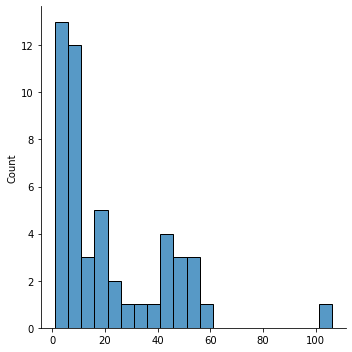

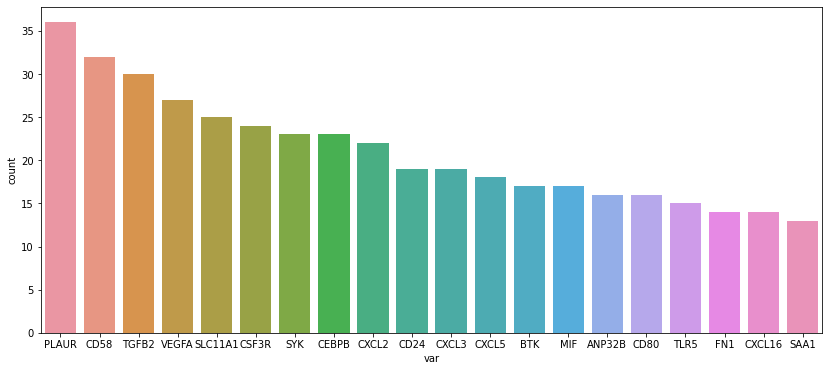

In [21]:
with open('rf_test2', 'rb') as fp:
    selected = pickle.load(fp)

lengths = [len(s) for s in selected]

plt.figure(figsize=(12,12))
sns.displot(lengths, binwidth=5)
plt.show()

flat = [item for sublist in selected for item in sublist]
count = dict(Counter(flat))

a = pd.DataFrame(flat, columns=["var"])

plt.figure(figsize=(14,6))
sns.countplot(data=a, x = "var", order=a["var"].value_counts().iloc[:20].index)
plt.show()

In [ ]:
path_imp = "./feat_select/rf_importances.csv"
path_sets = "./feat_select/rf_based.csv"
df = data[union1+[target]]
n_repeats = 20

rf_select = tese_func.rf_feature_selection(df, target, path_imp, path_sets, pre_importances=False, n_repeats=n_repeats, verbose=2)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
path_imp = "./feat_select/rf_importances.csv"
path_sets = "./feat_select/rf_based.csv"
df = data[union1].iloc[:,selected_features]
df[target] = data[target]
n_repeats = 20

tese_func.rf_feature_selection(df, target, path_imp, path_sets, pre_importances=False, 
                               n_repeats=n_repeats, verbose=2)

In [ ]:
a = ['SYK', 'SLC11A1', 'CXCL5', 'PLAUR']
t = []
cols = data.columns.tolist()
for i in a:
    t.append(i)
    ind = cols.index(i)
    t.append(cols[related_features[ind]])
t

